In [3]:
import requests
import pandas as pd
import numpy as np
from pandas.io.json import json_normalize
import json
from flatten_json import flatten

# Plotting settings
import mpld3
mpld3.enable_notebook()
%matplotlib notebook
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (15,5)

In [4]:
class farm_data():
    
    def __init__(self, sensor_id, start_date, end_date, max_items = '1000', auth_token = None):
        
        self.dev_id = sensor_id
        self.device_uid = 'device_uid='+self.dev_id+'&'
        self.date = 'start_date='+start_date+'&'+'end_date='+end_date
        self.limit = '&limit='+max_items
        self.base_url = 'http://pwrnet-158117.appspot.com/api/v1/farm_device_data/?'
        self.auth_token = 'adde8a3993d902769197c1db98a9ab0e88dce587'
        self.headers = {'Authorization': 'Token ' + self.auth_token}
        
    def get_data(self, url=None):
        # Check to see if id is valid
        # The first case should not be none - it should be the url -> maybe remove the url=None
        if url is None:
            try:
                resp = requests.get(self.base_url+self.device_uid+self.date+self.limit, headers=self.headers)
                resp.raise_for_status()
            except requests.exceptions.HTTPError as err:
                return None
        else:
            try:
                resp = requests.get(url, headers=self.headers)
                resp.raise_for_status()
            except requests.exceptions.HTTPError as err:
                return None
        
        data = resp.json()['results']
        if resp.json()['next'] is None:
            return data
        else:
            return (data+self.get_data(url=resp.json()['next']))
            
            
    def convert2pandas(self, raw_data):
        dev_id = int(self.dev_id)
        if raw_data is None:
            print('No data collected')
            return None
        # Checking for Lora sensors - need to automate this in case the number of lora devices grow (pull info from FarmDevice endpoint or check what type of sensr the id corresponds to)
        if dev_id < 24 and dev_id > 0:
            data_flat = [flatten(json.loads(d['device_data'])) for d in raw_data]
            return pd.DataFrame(data_flat)
        # Checking for egauge
        elif dev_id == 46613:
            data_flat = [flatten(json.loads(d['device_data'])) for d in raw_data]
            df = pd.DataFrame(data_flat)
            return df[df.columns[~df.columns.str.contains('raw_')]] # returning only processed data
        # Checking for battery
        elif dev_id == 67682 or dev_id == 67670:
            data_flat = [flatten(d['device_data']) for d in raw_data]
            return pd.DataFrame(data_flat) 
        # Checking for STD
        elif dev_id == 100000:
            df_list = []
            for d in raw_data:
                df_list.append(pd.DataFrame(d['device_data']))
            return pd.concat(df_list)
        else:
            print('No parsing available for this device ID')
            return None


# Sonnen

In [3]:
sonnen_object = farm_data('67682','2019-08-28', '2019-09-15', max_items = '1000')
sonnen_data = sonnen_object.get_data()
sonnen_pd = sonnen_object.convert2pandas(sonnen_data)
sonnen_pd.head(20)

,USOC,RSOC,Timestamp,Production_W,Consumption_W,Ubat,batt_id,Fac,Uac,IsSystemInstalled,GridFeedIn_W,Pac_total_W
0,97,97,2019-08-27 17:04:06,369,0,53,67682,60,244,1,0,NaN
1,97,97,2019-08-27 17:19:04,320,0,53,67682,60,239,1,0,NaN
2,97,97,2019-08-27 17:04:04,369,0,53,67682,60,244,1,0,NaN
3,97,97,2019-08-27 17:14:04,332,0,53,67682,60,239,1,0,NaN
4,97,97,2019-08-27 17:29:07,284,0,53,67682,60,243,1,0,NaN
5,97,97,2019-08-27 17:09:04,355,0,53,67682,60,241,1,0,NaN
6,97,97,2019-08-27 17:34:04,273,0,53,67682,60,243,1,0,NaN
7,97,97,2019-08-27 17:44:04,221,0,53,67682,60,239,1,0,NaN
8,97,97,2019-08-27 18:04:05,167,0,53,67682,60,241,1,0,NaN
9,97,97,2019-08-27 17:24:10,292,0,53,67682,60,244,1,0,NaN


# Lora

In [6]:
lora_object = farm_data('01','2019-08-28', '2019-09-15', max_items = '1000')
lora_01_data = lora_object.get_data()
lora_pd = lora_object.convert2pandas(lora_01_data)

In [7]:
lora_pd = lora_pd[['timestamp', 'rel_humidity','temperature']]
lora_pd['timestamp'] = pd.to_datetime(lora_pd['timestamp'], utc=True)
lora_pd.set_index('timestamp', inplace=True)
lora_pd.index = lora_pd.index.tz_convert('America/Los_Angeles')
lora_pd = lora_pd.sort_index()

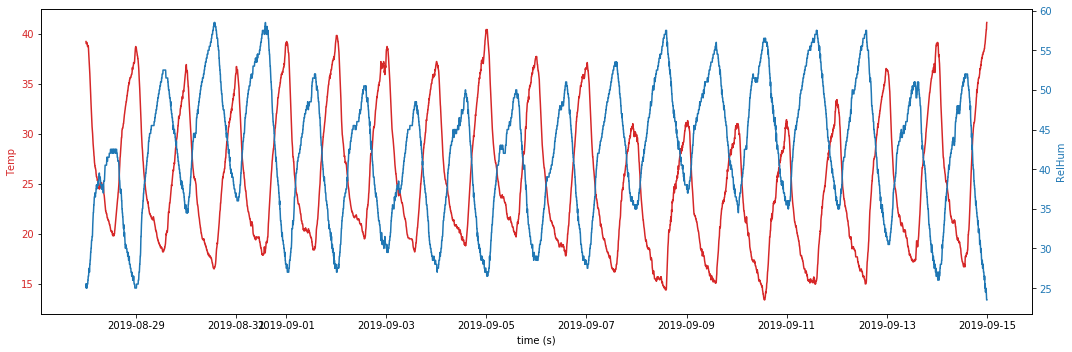

In [8]:
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('time (s)')
ax1.set_ylabel('Temp', color=color)  # we already handled the x-label with ax1
ax1.plot(lora_pd['temperature'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('RelHum', color=color)
ax2.plot(lora_pd['rel_humidity'], color=color)
ax2.tick_params(axis='y', labelcolor=color)



fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

In [9]:
lora_pd.head()

,rel_humidity,temperature
timestamp,,
2019-08-27 17:03:47-07:00,25.5,39.2
2019-08-27 17:08:46-07:00,25.0,39.0
2019-08-27 17:13:47-07:00,25.5,39.0
2019-08-27 17:18:47-07:00,25.5,39.0
2019-08-27 17:23:47-07:00,25.5,39.0


# EGauge

In [9]:
# Change date range for data - Note: Latest fix on e-gauge data was August 26th 2019. Recommended to select days after this date
start_date = '2019-10-05'
end_date = '2019-10-07'
egauge_object = farm_data('46613',start_date, end_date, max_items = '1000')
egauge_data = egauge_object.get_data()
egauge_pd = egauge_object.convert2pandas(egauge_data)

In [10]:
egauge_pd = egauge_pd[['processed_timestamp', 'processed_CONTROL_FAN_POWER', 'processed_CONTROL_FAN_POWER*', 'processed_POWER_TEST_PEN', 'processed_POWER_TEST_PEN*', 'processed_SHED_POWER', 'processed_POWER_CIRCUIT1', 'processed_POWER_CIRCUIT2','processed_L1 - VOLTAGE_C', 'processed_L2 - VOLTAGE_A']]
egauge_pd['processed_timestamp'] = pd.to_datetime(egauge_pd['processed_timestamp'], utc=True)
egauge_pd.set_index('processed_timestamp', inplace=True)
egauge_pd.index = egauge_pd.index.tz_convert('America/Los_Angeles')
egauge_pd = egauge_pd.sort_index()
egauge_pd['datetime'] = egauge_pd.index # creating datetime column
egauge_pd['date'] = egauge_pd['datetime'].dt.date # creating date column
egauge_pd['processed_POWER_CIRCUIT2'] = -egauge_pd['processed_POWER_CIRCUIT2']
egauge_pd['processed_POWER_CIRCUIT1'] = -egauge_pd['processed_POWER_CIRCUIT1']
egauge_pd['processed_SHED_POWER'] = -egauge_pd['processed_SHED_POWER']
egauge_pd['processed_CONTROL_FAN_POWER'] = -egauge_pd['processed_CONTROL_FAN_POWER']
# egauge_pd['processed_CONTROL_FAN_POWER*'] = -egauge_pd['processed_CONTROL_FAN_POWER*']
egauge_pd['processed_POWER_TEST_PEN'] = -egauge_pd['processed_POWER_TEST_PEN']
# egauge_pd['processed_POWER_TEST_PEN*'] = -egauge_pd['processed_POWER_TEST_PEN*']
egauge_pd['POWER_TEST_FANS'] = egauge_pd['processed_POWER_CIRCUIT1']+egauge_pd['processed_POWER_CIRCUIT2']
egauge_pd['POWER_TEST_PEN'] = egauge_pd['POWER_TEST_FANS'] + egauge_pd['processed_SHED_POWER']

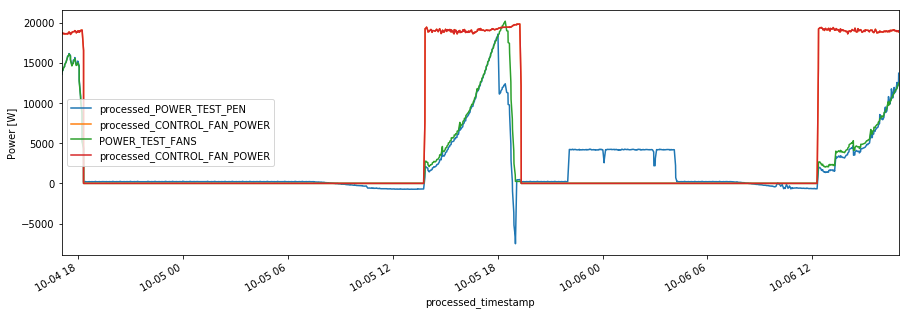

In [12]:
# Real Power
ax = egauge_pd.plot(y=['processed_POWER_TEST_PEN', 'processed_CONTROL_FAN_POWER', 'POWER_TEST_FANS', 'processed_CONTROL_FAN_POWER'])
ax.set_ylabel('Power [W]')
plt.show()

# STD

In [9]:
std_object = farm_data('100000','2019-08-28', '2019-09-15', max_items = '1000')
std_data = std_object.get_data()
std_pd = std_object.convert2pandas(std_data)

/anaconda2/envs/venv_egauge/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/anaconda2/envs/venv_egauge/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/anaconda2/envs/venv_egauge/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the document

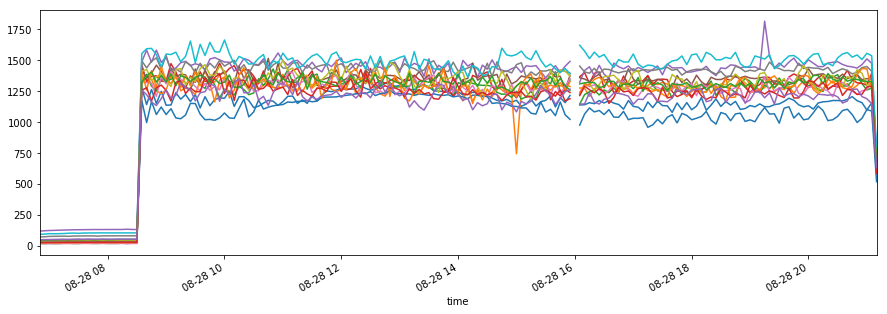

In [10]:
fans = std_pd.groupby('serial_number')
fans.first()
# # sensor = 282322

blenders_id = ['697151','766935','697145','766944','697149','766929','697160','697147','697156','766940','697153','697144','697146','766936','697157']
fans_energy = dict.fromkeys(blenders_id, None)

for b in blenders_id:
    fan = fans.get_group(int(b))
    fan = fan.drop_duplicates()
    fan['time'] = pd.to_datetime(fan['time'], utc=True)
    fan['date'] = fan['time'].dt.date # creating date column
    fan.set_index('time', inplace=True)
    fan.index = fan.index.tz_convert('America/Los_Angeles')
    fan = fan.sort_index()
    day = fan.loc[str(fan['date'].unique()[0])]
    day['Power'] = day['pv_power']+day['grid_power']
    energy = day['Power'].sum()/12000
    fans_energy[b] = energy
    fan5min = day['Power'].resample('5min').mean()
    fan5min.plot()



In [11]:
fanpv_list = []
fangrid_list = []
for b in blenders_id:
    fan = fans.get_group(int(b))
    fan['time'] = pd.to_datetime(fan['time'], utc=True)
    fan['date'] = fan['time'].dt.date # creating date column
    fan.set_index('time', inplace=True)
    fan.index = fan.index.tz_convert('America/Los_Angeles')
    fan = fan.sort_index()
    fan = fan.drop_duplicates()
    fan5min_pv = fan['pv_power'].resample('5min').mean()
    fanpv_list.append(fan5min_pv)
    fan5min_grid = fan['grid_power'].resample('5min').mean()
    fangrid_list.append(fan5min_grid)
    


/anaconda2/envs/venv_egauge/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/anaconda2/envs/venv_egauge/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


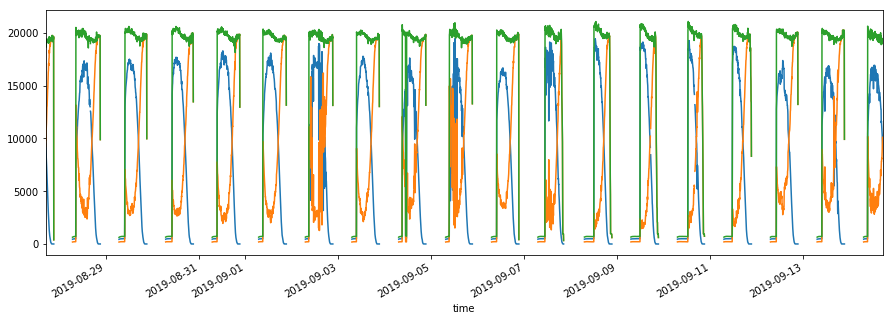

In [12]:
fanpv = sum(fanpv_list)
fangrid = sum(fangrid_list)
fantotal = fangrid+fanpv
fanpv.plot()
fangrid.plot()
fantotal.plot()
# print(max(egauge_pd['POWER_TEST_FANS']) - max(fanpv))